In [9]:
import pandas as pd


data = pd.read_csv('social-bias.csv', encoding='latin-1')

In [10]:
from ast import literal_eval

# Define a function to convert annotations to one-hot vectors
def annotation_to_one_hot(annotation):
    mapping = {
        1.0: (1, 0, 0),
        0.5: (0, 1, 0),
        0.0: (0, 0, 1)
    }
    return [mapping[ann] for ann in literal_eval(annotation)]

# Apply the function to the 'annotations' column and create a new column 'annotations_one_hot'
data['annotations_one_hot'] = data['annotations'].apply(annotation_to_one_hot)


data = data[data['annotations'].apply(lambda x: len(literal_eval(x)) >= 3)]


data.head()


,post_id,post,annotators,annotations,annotators_meta_data,annotations_meta_data,annotations_one_hot
0,1,RT @_LexC__: I'm convinced that some of y'all ...,"[1, 2, 3]","[1.0, 0.5, 0.5]","{1: {'annotatorGender': 'woman', 'annotatorMin...","{1: {'sexYN': 0.0, 'sexPhrase': nan, 'targetMi...","[(1, 0, 0), (0, 1, 0), (0, 1, 0)]"
1,2,RT @iBeZo: Stupid fucking nigger LeBron. You f...,"[4, 5, 6]","[1.0, 1.0, 1.0]","{4: {'annotatorGender': 'man', 'annotatorMinor...","{4: {'sexYN': 0.0, 'sexPhrase': nan, 'targetMi...","[(1, 0, 0), (1, 0, 0), (1, 0, 0)]"
4,5,RT @rihanna: I ain't got no type...bad bitches...,"[9, 10, 11]","[0.0, 0.0, 0.0]","{9: {'annotatorGender': 'woman', 'annotatorMin...","{9: {'sexYN': 0.0, 'sexPhrase': nan, 'targetMi...","[(0, 0, 1), (0, 0, 1), (0, 0, 1)]"
7,8,RT @_danieebro: all these bitches fake if you ...,"[3, 16, 17]","[1.0, 1.0, 0.0]","{3: {'annotatorGender': 'man', 'annotatorMinor...","{3: {'sexYN': 0.0, 'sexPhrase': nan, 'targetMi...","[(1, 0, 0), (1, 0, 0), (0, 0, 1)]"
8,9,RT @__nijel: Niggas be out here loving ALL the...,"[18, 19, 20]","[1.0, 1.0, 0.0]","{18: {'annotatorGender': 'woman', 'annotatorMi...","{18: {'sexYN': 0.0, 'sexPhrase': nan, 'targetM...","[(1, 0, 0), (1, 0, 0), (0, 0, 1)]"


# **Crowd Truth**

In [11]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine



def create_annotation_vectors(data):
    annotations = {}
    for idx, row in data.iterrows():
        tweet = row['post']
        annotations_list = row['annotations_one_hot']  # Directly use the list of one-hot encoded vectors
        if tweet not in annotations:
            annotations[tweet] = []
        annotations[tweet].extend(annotations_list)

    vectors = {}
    for tweet, annos in annotations.items():
        vec = np.zeros(3)
        for anno in annos:
            vec[np.argmax(anno)] += 1  # Find the index of the maximum value
        vectors[tweet] = vec / len(annos)
    return vectors

annotation_vectors = create_annotation_vectors(data)

# Debug: Print the annotations and vectors for the first tweet
first_tweet = list(annotation_vectors.keys())[0]
print(f"Annotations for first tweet: {data[data['post'] == first_tweet]['annotations_one_hot'].values}")
print(f"Annotation Vector for first tweet: {annotation_vectors[first_tweet]}")

# Compute quality metrics
def compute_worker_sentence_disagreement(data, vectors):
    annotations = {}
    for idx, row in data.iterrows():
        tweet = row['post']
        annotations_list = row['annotations_one_hot']  # Directly use the list of one-hot encoded vectors
        if tweet not in annotations:
            annotations[tweet] = []
        annotations[tweet].extend(annotations_list)

    scores = {}
    for tweet, annos in annotations.items():
        tweet_vec = vectors[tweet]
        worker_scores = []
        for anno in annos:
            worker_vec = np.zeros(3)
            worker_vec[np.argmax(anno)] = 1  # Find the index of the maximum value
            worker_scores.append(cosine(worker_vec, tweet_vec))
        scores[tweet] = np.mean(worker_scores)
    return scores

worker_sentence_disagreement = compute_worker_sentence_disagreement(data, annotation_vectors)

def compute_sentence_clarity(vectors):
    clarity = {tweet: max(vec) for tweet, vec in vectors.items()}
    return clarity

sentence_clarity = compute_sentence_clarity(annotation_vectors)

# Filter low-quality annotations and high-clarity tweets
high_clarity_tweets = {tweet: vec for tweet, vec in annotation_vectors.items() if sentence_clarity[tweet] > 0.5}

# Creating DataFrames for better visualization
df_annotation_vectors = pd.DataFrame(list(annotation_vectors.items()), columns=['Tweet', 'Annotation Vector'])
df_worker_sentence_disagreement = pd.DataFrame(list(worker_sentence_disagreement.items()), columns=['Tweet', 'Worker-Sentence Disagreement'])
df_sentence_clarity = pd.DataFrame(list(sentence_clarity.items()), columns=['Tweet', 'Sentence Clarity'])
df_high_clarity_tweets = pd.DataFrame(list(high_clarity_tweets.items()), columns=['Tweet', 'High Clarity Annotation Vector'])



Annotations for first tweet: [list([(1, 0, 0), (0, 1, 0), (0, 1, 0)])]
Annotation Vector for first tweet: [0.33333333 0.66666667 0.        ]


In [12]:
df_annotation_vectors.head(100)

,Tweet,Annotation Vector
0,RT @_LexC__: I'm convinced that some of y'all ...,"[0.3333333333333333, 0.6666666666666666, 0.0]"
1,RT @iBeZo: Stupid fucking nigger LeBron. You f...,"[1.0, 0.0, 0.0]"
2,RT @rihanna: I ain't got no type...bad bitches...,"[0.0, 0.0, 1.0]"
3,RT @_danieebro: all these bitches fake if you ...,"[0.6666666666666666, 0.0, 0.3333333333333333]"
4,RT @__nijel: Niggas be out here loving ALL the...,"[0.6666666666666666, 0.0, 0.3333333333333333]"
...,...,...
95,"@mike_ray7 congratulations, you are officially...","[1.0, 0.0, 0.0]"
96,These ratchet hoes are something else this sch...,"[1.0, 0.0, 0.0]"
97,"@kay_laa_laa if you can't stand the heat, get ...","[0.3333333333333333, 0.3333333333333333, 0.333..."
98,@mfsasso or jim crow laws segregation lynching...,"[0.0, 0.6666666666666666, 0.3333333333333333]"


In [16]:
df_worker_sentence_disagreement.head(100)

,Tweet,Worker-Sentence Disagreement
0,RT @_LexC__: I'm convinced that some of y'all ...,0.254644
1,RT @iBeZo: Stupid fucking nigger LeBron. You f...,0.000000
2,RT @rihanna: I ain't got no type...bad bitches...,0.000000
3,RT @_danieebro: all these bitches fake if you ...,0.254644
4,RT @__nijel: Niggas be out here loving ALL the...,0.254644
...,...,...
95,"@mike_ray7 congratulations, you are officially...",0.000000
96,These ratchet hoes are something else this sch...,0.000000
97,"@kay_laa_laa if you can't stand the heat, get ...",0.422650
98,@mfsasso or jim crow laws segregation lynching...,0.254644


In [17]:
df_sentence_clarity.head(100)

,Tweet,Sentence Clarity
0,RT @_LexC__: I'm convinced that some of y'all ...,0.666667
1,RT @iBeZo: Stupid fucking nigger LeBron. You f...,1.000000
2,RT @rihanna: I ain't got no type...bad bitches...,1.000000
3,RT @_danieebro: all these bitches fake if you ...,0.666667
4,RT @__nijel: Niggas be out here loving ALL the...,0.666667
...,...,...
95,"@mike_ray7 congratulations, you are officially...",1.000000
96,These ratchet hoes are something else this sch...,1.000000
97,"@kay_laa_laa if you can't stand the heat, get ...",0.333333
98,@mfsasso or jim crow laws segregation lynching...,0.666667


In [19]:
df_high_clarity_tweets.head(100)

,Tweet,High Clarity Annotation Vector
0,RT @_LexC__: I'm convinced that some of y'all ...,"[0.3333333333333333, 0.6666666666666666, 0.0]"
1,RT @iBeZo: Stupid fucking nigger LeBron. You f...,"[1.0, 0.0, 0.0]"
2,RT @rihanna: I ain't got no type...bad bitches...,"[0.0, 0.0, 1.0]"
3,RT @_danieebro: all these bitches fake if you ...,"[0.6666666666666666, 0.0, 0.3333333333333333]"
4,RT @__nijel: Niggas be out here loving ALL the...,"[0.6666666666666666, 0.0, 0.3333333333333333]"
...,...,...
95,"Bad bitches from Oakland, she could beeee a model","[0.3333333333333333, 0.0, 0.6666666666666666]"
96,' This niggah pharrell or whatever this niggah...,"[1.0, 0.0, 0.0]"
97,RT @_TyMoore: For all those watching that so r...,"[1.0, 0.0, 0.0]"
98,"RT @Shaa_Jenkins: If I hit ya nigga , bitch I'...","[0.6666666666666666, 0.0, 0.3333333333333333]"


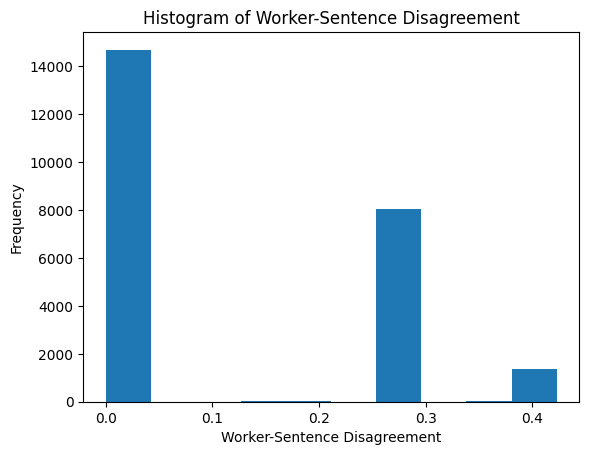

In [14]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(df_worker_sentence_disagreement['Worker-Sentence Disagreement'], bins=10)
plt.xlabel('Worker-Sentence Disagreement')
plt.ylabel('Frequency')
plt.title('Histogram of Worker-Sentence Disagreement')
plt.show()

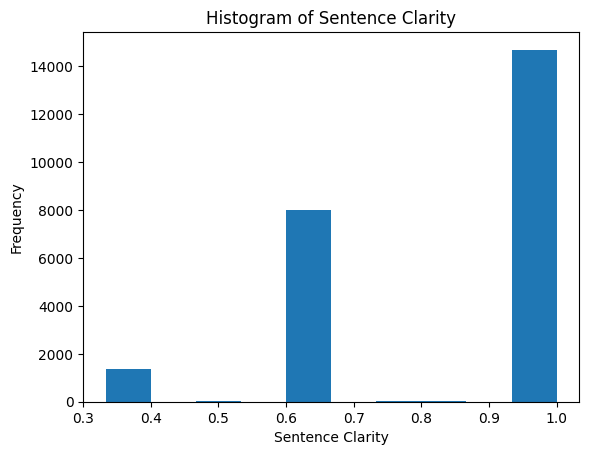

In [18]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(df_sentence_clarity['Sentence Clarity'], bins=10)
plt.xlabel('Sentence Clarity')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Clarity')
plt.show()
